In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)
%matplotlib inline
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
print("Environment setup complete")




# Load data and preprocess
# Load datasets
train_raw = pd.read_csv('training.csv')
test_raw = pd.read_csv('testing.csv')

def filter_classes(df):
    """保留class为s和d的样本"""
    return df[df['class'].isin(['s', 'd'])].copy()

train_df = filter_classes(train_raw)
test_df = filter_classes(test_raw)

# Drop pred_minus_obs columns

cols_to_drop = [c for c in train_df.columns if c.startswith('pred_minus_obs')]
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# 编码标签 (s->0, d->1)
train_df['class'] = train_df['class'].map({'s':0, 'd':1})
test_df['class'] = test_df['class'].map({'s':0, 'd':1})


# 显示数据概览
print("\nData Overview:")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nCategory distribution:")
print("Training set:\n", train_df['class'].value_counts())
print("\nTest Set:\n", test_df['class'].value_counts())

# 分离特征和标签
feature_cols = [f'b{i}' for i in range(1,10)]
X_train = train_df[feature_cols]
y_train = train_df['class']
X_test = test_df[feature_cols]
y_test = test_df['class']



#%% 特征标准化
# 原始数据备份
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()


Environment setup complete

Data Overview:
Training set shape: (241, 10)
Test set shape: (113, 10)

Category distribution:
Training set:
 class
0    136
1    105
Name: count, dtype: int64

Test Set:
 class
0    59
1    54
Name: count, dtype: int64


In [2]:
# Task 1: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nStandardization completed (Mean=0, variance=1)")
print(f"Example original data mean: {np.mean(X_train_raw):.2f}")
print(f"Standardized mean: {np.mean(X_train_scaled):.2f}")




Standardization completed (Mean=0, variance=1)
Example original data mean: 62.23
Standardized mean: -0.00



SVM Model comparison

standardizationOptimal parameters: {'C': 1, 'kernel': 'rbf'}
Training accuracy: 0.9710
Testing accuracy: 0.9912


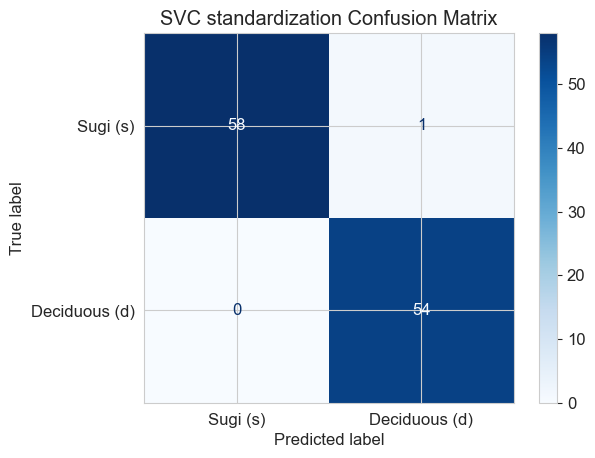


Not standardizedOptimal parameters: {'C': 10, 'kernel': 'rbf'}
Training accuracy: 0.9710
Testing accuracy: 0.9912


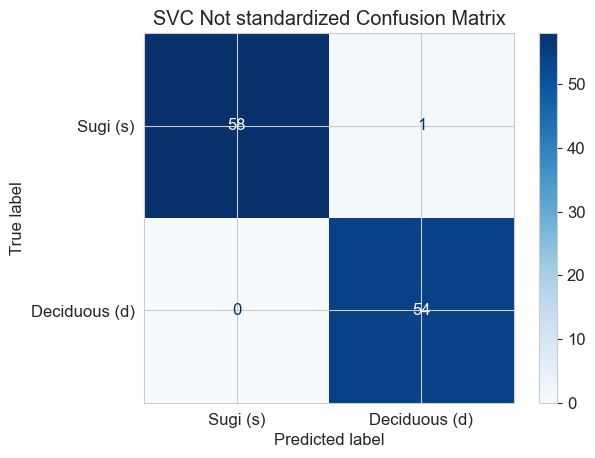


Softmax Regression comparison


In [3]:
# Task 2-4: SVM with Grid Search
#%% 通用评估函数
def full_evaluation(model, params, X_tr, y_tr, X_te, y_te, scaled=True):
    """
    Complete model evaluation process
    parameter:
        model : Model Object
        params : Grid search parameter dictionary
        X_tr, y_tr : Training Data
        X_te, y_te : Testing Data
        scaled : Whether to use normalized data (for display)
    """
    # 网格搜索
    gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    gs.fit(X_tr, y_tr)
    
    # 最佳模型评估
    best_model = gs.best_estimator_
    train_pred = best_model.predict(X_tr)
    test_pred = best_model.predict(X_te)
    
    # 计算指标
    train_acc = accuracy_score(y_tr, train_pred)
    test_acc = accuracy_score(y_te, test_pred)
    
    # 打印结果
    status = "standardization" if scaled else "Not standardized"
    print(f"\n{status}Optimal parameters: {gs.best_params_}")
    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Testing accuracy: {test_acc:.4f}")
    
    # 混淆矩阵
    cm = confusion_matrix(y_te, test_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Sugi (s)', 'Deciduous (d)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{type(model).__name__} {status} Confusion Matrix")
    plt.show()
    
    return gs.best_estimator_

#%% SVM模型比较
print("\n" + "="*50)
print("SVM Model comparison")
print("="*50)


# 参数网格
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']
}

# 标准化数据训练
svm_scaled = full_evaluation(
    SVC(), 
    svm_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# 原始数据训练
svm_raw = full_evaluation(
    SVC(),
    svm_params,
    X_train_raw, y_train,
    X_test_raw, y_test,
    scaled=False
)

#%% Softmax回归比较
print("\n" + "="*50)
print("Softmax Regression comparison")
print("="*50)



standardizationOptimal parameters: {'C': 1, 'penalty': 'l2'}
Training accuracy: 0.9627
Testing accuracy: 0.9912


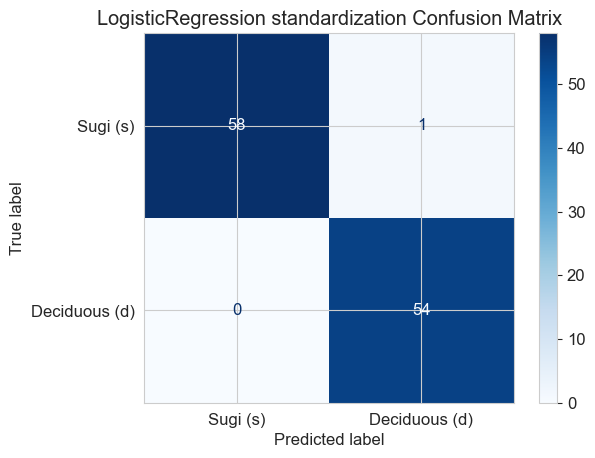


standardizationOptimal parameters: {'penalty': None}
Training accuracy: 0.9585
Testing accuracy: 0.9912


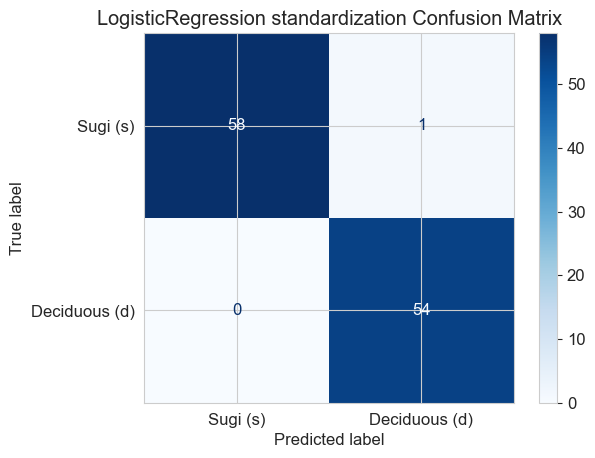


Not standardizedOptimal parameters: {'C': 0.01, 'penalty': 'l2'}
Training accuracy: 0.9544
Testing accuracy: 0.9912


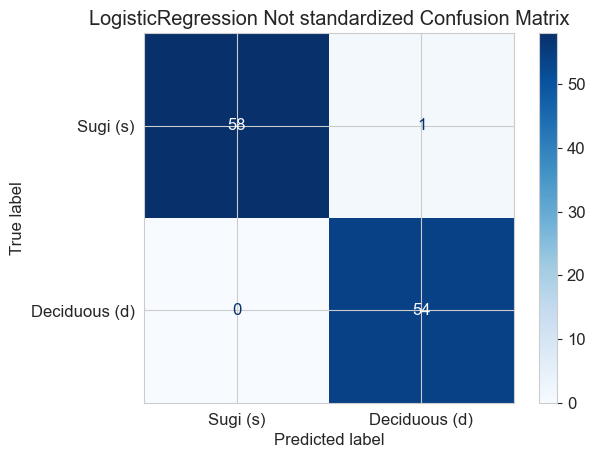

In [11]:
# 优化后的参数网格（分离带正则化和无正则化的情况）
lr_params = {
    'penalty': ['l2'],  # 仅保留l2正则化
    'C': [0.01, 0.1, 1, 10]
}

# 单独处理无正则化的情况
lr_params_none = {
    'penalty': [None]
}

# 标准化数据训练
lr_scaled = full_evaluation(
    LogisticRegression(max_iter=1000),
    lr_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# 无正则化训练（单独执行）
lr_none = full_evaluation(
    LogisticRegression(max_iter=1000),
    lr_params_none,
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# 原始数据训练
lr_raw = full_evaluation(
    LogisticRegression(max_iter=1000),
    lr_params,
    X_train_raw, y_train,
    X_test_raw, y_test,
    scaled=False
)


K-NN 模型比较

standardizationOptimal parameters: {'n_neighbors': 9, 'weights': 'distance'}
Training accuracy: 1.0000
Testing accuracy: 0.9912


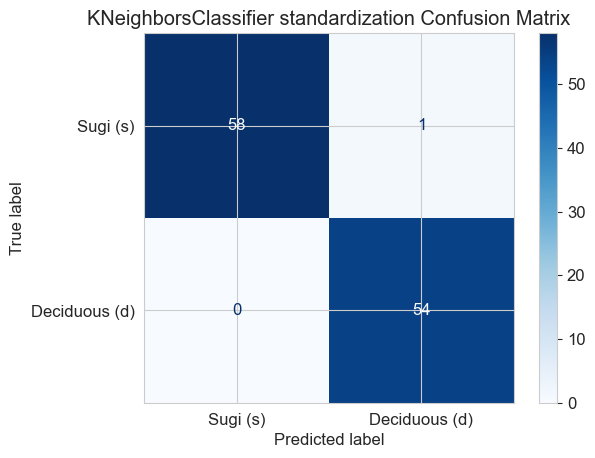


Not standardizedOptimal parameters: {'n_neighbors': 7, 'weights': 'uniform'}
Training accuracy: 0.9627
Testing accuracy: 0.9912


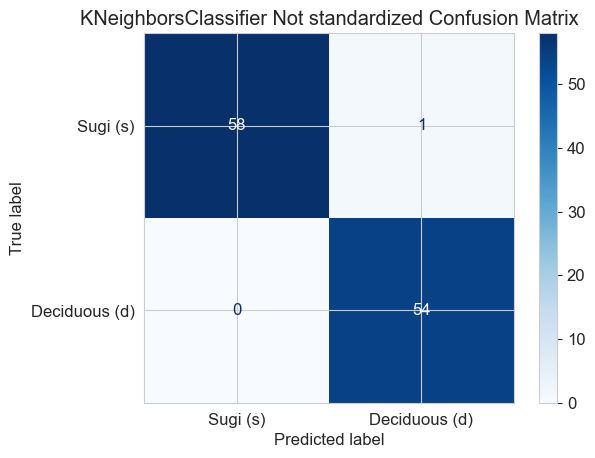

In [7]:

#%% K-NN模型比较
print("\n" + "="*50)
print("K-NN 模型比较")
print("="*50)

knn_params = {
    'n_neighbors': list(range(1, 21, 2)),
    'weights': ['uniform', 'distance']
}

# 标准化数据训练
knn_scaled = full_evaluation(
    KNeighborsClassifier(),
    knn_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# 原始数据训练
knn_raw = full_evaluation(
    KNeighborsClassifier(),
    knn_params,
    X_train_raw, y_train,
    X_test_raw, y_test,
    scaled=False
)



最终模型性能对比:
          Model  Test Accuracy
   SVM (Scaled)        0.99115
      SVM (Raw)        0.99115
LogReg (Scaled)        0.99115
   LogReg (Raw)        0.99115
  K-NN (Scaled)        0.99115
     K-NN (Raw)        0.99115

提示：当前SVM模型不使用线性核，无法显示特征重要性

绘制学习曲线...


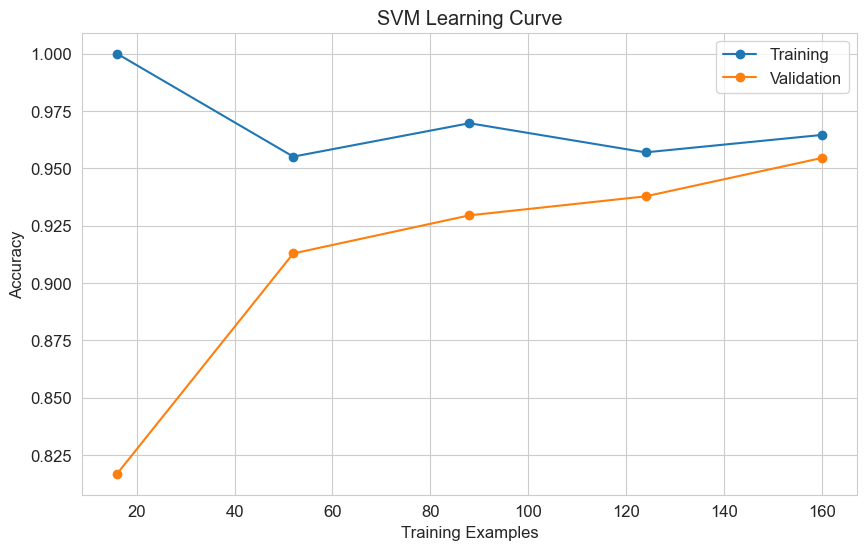

In [8]:
#%% 结果汇总
results = [
    ['SVM (Scaled)', svm_scaled, svm_scaled.score(X_test_scaled, y_test)],
    ['SVM (Raw)', svm_raw, svm_raw.score(X_test_raw, y_test)],
    ['LogReg (Scaled)', lr_scaled, lr_scaled.score(X_test_scaled, y_test)],
    ['LogReg (Raw)', lr_raw, lr_raw.score(X_test_raw, y_test)],
    ['K-NN (Scaled)', knn_scaled, knn_scaled.score(X_test_scaled, y_test)],
    ['K-NN (Raw)', knn_raw, knn_raw.score(X_test_raw, y_test)]
]

results_df = pd.DataFrame(results, columns=['Model', 'Best Estimator', 'Test Accuracy'])
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n最终模型性能对比:")
print(results_df[['Model', 'Test Accuracy']].to_string(index=False))

#%% 特征重要性分析（以SVM为例）
if hasattr(svm_scaled, 'coef_'):
    plt.figure(figsize=(10,6))
    importance = pd.Series(np.abs(svm_scaled.coef_[0]), index=feature_cols)
    importance.sort_values().plot(kind='barh')
    plt.title('SVM Feature Importance (Linear Kernel)')
    plt.xlabel('Coefficient Magnitude')
    plt.show()
else:
    print("\n提示：当前SVM模型不使用线性核，无法显示特征重要性")

#%% 学习曲线示例（以最佳模型为例）
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

print("\n绘制学习曲线...")
plot_learning_curve(svm_scaled, X_train_scaled, y_train, 'SVM Learning Curve')